# IMPORTS FOR COLABORATORY ONLY

In [ ]:
!pip install git+https://github.com/pydata/pandas-datareader.git
!pip install git+https://github.com/scubamut/fintools.git
!pip install cvxopt
!pip install pyfolio
!pip install ffn
!pip install itable

# IMPORTS FOR BACKTESTS

In [33]:
from __future__ import print_function
from IPython.utils.path import get_ipython_dir
print(get_ipython().profile_dir.location)
 
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta,timezone
import pytz
import talib
import itable
import ffn

from fintools import get_DataArray, endpoints, backtest, show_return_table
from fintools import Parameters
 
%matplotlib inline

/home/scubamut/.ipython/profile_default


# <span class="girk">STEP BY STEP BACKTEST</span>

## <span class="girk"><span class="girk">EXAMPLE 1 - single strategy, RS_DM</span>, manual parameters</span>

In [4]:
#*****************************************************************
# Load historical data
#****************************************************************** 
 
frequency = 'M'
    
cash_proxy = 'VUSTX'
risk_free = 0

rs_lookback = 1
risk_lookback = 1
n_top = 3
 
# these are the ETFs used by Systematic Investor (2005 - today)
assets = ['VCVSX','VWINX','VWEHX','VGHCX','VFIIX','VWAHX','FGOVX','FFXSX']
 
# these funds could be used as proxies for the Philbrick results
#assets = ['^GSPC', 'VEURX', 'FJPNX', 'FEMKX', 'FRESX','EGLRX', 'VFITX', 'VUSTX', 'VGPMX', 'GOLDX' ]
 
data_path = '/home/scubamut/MEGAsync/01_WORK_IN_PROGRESS/DATA'
 
# get data
tickers = assets.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime.today().replace(tzinfo=timezone.utc)

da = get_DataArray(tickers,start,end)
# don't forget to ffill()
data = da.to_pandas().transpose(1,2,0).ffill()
data

VWAHX OK
VFIIX OK
VGHCX OK
FGOVX OK
VWEHX OK
VCVSX OK
FFXSX OK
VUSTX OK
VWINX OK


/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



<class 'pandas.core.panel.Panel'>
Dimensions: 9 (items) x 4841 (major_axis) x 6 (minor_axis)
Items axis: FFXSX to VWINX
Major_axis axis: 2000-01-03 00:00:00 to 2019-04-01 00:00:00
Minor_axis axis: high to adj close

In [7]:
data1 = data.copy()[:,:,'close']

/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


In [10]:
# If necessary
inception_dates = pd.DataFrame([data1[ticker].first_valid_index() for ticker in data1.columns], 
                               index=data1.keys(), columns=['inception'])
print (inception_dates)

       inception
FFXSX 2000-01-03
FGOVX 2000-01-03
VCVSX 2000-01-03
VFIIX 2000-01-03
VGHCX 2000-01-03
VUSTX 2000-01-03
VWAHX 2000-01-03
VWEHX 2000-01-03
VWINX 2000-01-03


In [13]:
prices = data[:,:,'adj close'].copy().dropna()
 
end_points = endpoints(period=frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]
prices_m[:3]

,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-01-31,5.439851,4.428442,4.077240,4.226287,26.228577,3.439002,4.219830,1.934887,6.611959
2000-02-29,5.480496,4.489141,4.508914,4.286113,26.785847,3.540874,4.282774,1.937619,6.413528
2000-03-31,5.523195,4.551577,4.540345,4.359500,28.986511,3.652116,4.381704,1.920046,6.772798


In [15]:
returns = prices_m[assets].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0
if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

returns[:3]

,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
2000-02-29,0.105874,-0.030011,0.001412,0.021247,0.014156,0.014916,0.013707,0.007472
2000-03-31,0.006971,0.056017,-0.009070,0.082158,0.017122,0.023099,0.013908,0.007791
2000-04-28,-0.049836,0.001593,0.007500,0.023139,-0.001285,-0.005106,-0.002195,0.002125


In [16]:
# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][assets].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0
elligible[:3]

,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
2000-02-29,True,False,False,True,False,True,False,False
2000-03-31,False,True,False,True,False,True,False,False
2000-04-28,False,False,True,True,False,False,False,True


In [17]:
# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)
elligible[:3]

,VCVSX,VWINX,VWEHX,VGHCX,VFIIX,VWAHX,FGOVX,FFXSX
Date,,,,,,,,
2000-02-29,0.333333,0.000000,0.000000,0.333333,0.0,0.333333,0.0,0.000000
2000-03-31,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.0,0.000000
2000-04-28,0.000000,0.000000,0.333333,0.333333,0.0,0.000000,0.0,0.333333


In [19]:
# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[assets] = (elligible * absolute_momentum_rule).dropna() 
weights[:10]

,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-02-29,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.000000,0.000000
2000-03-31,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.333333,0.000000,0.333333
2000-04-28,0.333333,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.333333,0.000000
2000-05-31,0.000000,0.000000,0.000000,0.333333,0.333333,0.0,0.000000,0.000000,0.333333
2000-06-30,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.333333,0.000000,0.000000
2000-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.333333,0.333333
2000-08-31,0.000000,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.000000,0.333333
2000-09-29,0.000000,0.000000,0.000000,0.333333,0.333333,0.0,0.000000,0.000000,0.333333
2000-10-31,0.000000,0.333333,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.333333


In [21]:
weights[cash_proxy] += 1 - weights[assets].sum(axis=1)
weights[:3]

,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-02-29,0.000000,0.0,0.333333,0.0,0.333333,0.0,0.333333,0.000000,0.000000
2000-03-31,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.333333,0.000000,0.333333
2000-04-28,0.333333,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.333333,0.000000


FIRST BUY DATE = 2000-02-29 00:00:00



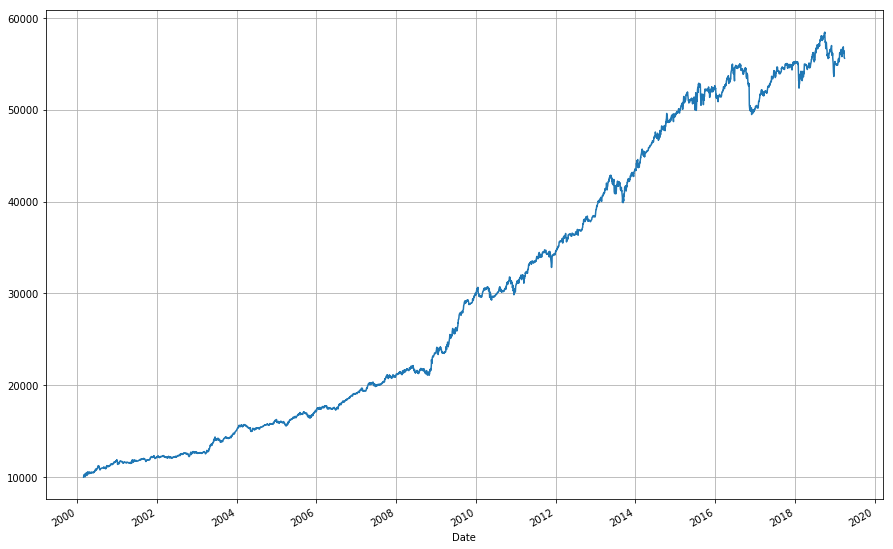

In [24]:
# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [25]:
p_weights.loc[rebalance_dates][:3]

,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-02-29,0.000000,0.0,0.333333,0.0,0.333333,0.0,0.333333,0.000000,0.000000
2000-03-31,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.333333,0.000000,0.333333
2000-04-28,0.333333,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.333333,0.000000


In [26]:
ffn.calc_perf_stats(p_value).display()

/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-packages/ffn/core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


Stats for None from 2000-02-29 00:00:00 - 2019-04-01 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
456.01%             1.54  9.41%   -10.05%

Annualized Returns:
mtd     3m     6m      ytd    1y     3y     5y     10y    incep.
------  -----  ------  -----  -----  -----  -----  -----  --------
-0.16%  1.20%  -4.61%  1.20%  1.19%  1.80%  4.19%  8.81%  9.41%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.54     1.60       1.21
mean    9.18%    9.15%      8.67%
vol     5.96%    5.72%      7.19%
skew    -0.32    0.24       0.55
kurt    4.24     2.94       1.21
best    2.23%    8.73%      26.85%
worst   -2.66%   -5.54%     -4.65%

Drawdowns:
max      avg       # days
-------  ------  --------
-10.05%  -0.85%      18.3

Misc:
---------------  ------
avg. up month    1.50%
avg. down month  -1.03%
up year %        89.47%
12m up %         95.45

In [29]:
show_return_table(p_value)

## <span class="girk">EXAMPLE 2 - using Parameters, RS_DM</span>

In [30]:
start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime.today().replace(tzinfo=timezone.utc)

In [45]:
# CHOOSE ONLY ONE

portfolios = {
#     'RS0001': { 'assets': ['VCVSX','VWEHX','VFIIX','FGOVX','VWAHX'], 
#                'start':start, 'end':end,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 2, 'frequency': 'M',
#               'cash_proxy': 'CASHX', 'risk_free': 0},
#     'RS0002': {'assets': ['MMHYX','FAGIX','VFIIX'], 
#                'start':start, 'end':end,            
#                'rs_lookback': 3, 'risk_lookback': 2, 'n_top': 1, 'frequency': 'M',
#               'cash_proxy': 'CASHX', 'risk_free': 0},
#     'RS0003': {'assets': ['MMHYX','FAGIX','VFIIX'], 
#                'start':start, 'end':end,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 1, 'frequency': 'Q',
#               'cash_proxy': 'CASHX', 'risk_free': 0},  
    
    'DM0001': {'assets': ['VCVSX','VWINX','VWEHX','VGHCX','VFIIX','VWAHX','FGOVX','FFXSX'], 
               'start':start, 'end':end,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'M',
              'cash_proxy': 'VUSTX', 'risk_free': 0},
    
#     'DM0002': {'assets': ['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX'], 
#                'start':start, 'end':end,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 5, 'frequency': 'M',
#               'cash_proxy': 'VFIIX', 'risk_free': 'FFXSX'},
    }

In [46]:
#*****************************************************************
# Load historical data
#****************************************************************** 

name = [i for i in portfolios.items()][0][0]
p = Parameters(portfolios[name])

cash_proxy = p.cash_proxy
risk_free = p.risk_free

rs_lookback = p.rs_lookback
risk_lookback = p.risk_lookback
n_top = p.n_top
# allocations = p.allocations
 
assets = p.assets

# get data
tickers = assets.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

da = get_DataArray(tickers,start,end)
# don't forget to ffill()
data = da.to_pandas().transpose(1,2,0).ffill()
 
data1 = data.copy()[:,:,'adj close']
inception_dates = pd.DataFrame([data1[ticker].first_valid_index() for ticker in data1.columns], 
                               index=data1.keys(), columns=['inception'])
 
# print (inception_dates)
 
prices = data.copy()[:,:,'adj close'].dropna()

end_points = endpoints(period=p.frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

prices_m[:3]

VWAHX OK
VFIIX OK
VGHCX OK
FGOVX OK
VWEHX OK
VCVSX OK
FFXSX OK
VUSTX OK
VWINX OK


/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-pa

,FFXSX,FGOVX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,
2000-01-31,5.439851,4.428442,4.077240,4.226287,26.228577,3.439002,4.219830,1.934887,6.611959
2000-02-29,5.480496,4.489141,4.508914,4.286113,26.785847,3.540874,4.282774,1.937619,6.413528
2000-03-31,5.523195,4.551577,4.540345,4.359500,28.986511,3.652116,4.381704,1.920046,6.772798


FIRST BUY DATE = 2000-02-29 00:00:00



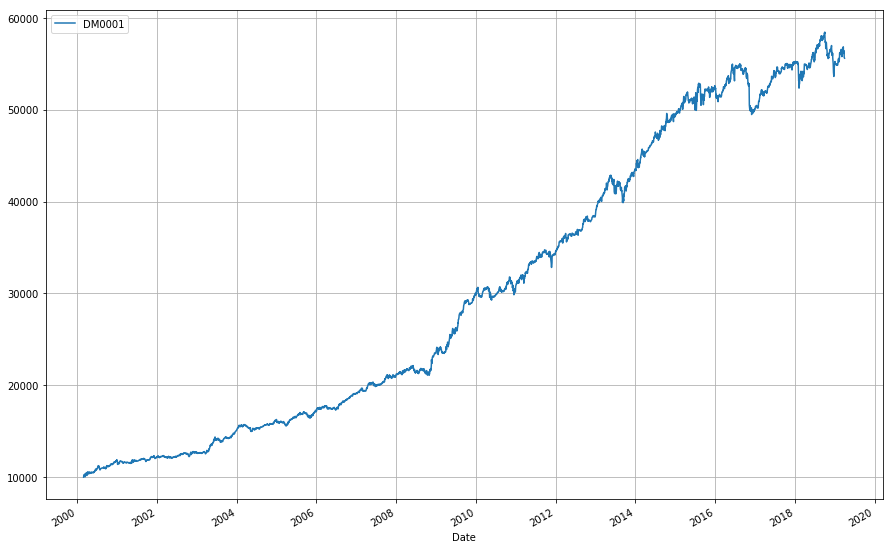

In [51]:
returns = prices_m[p.assets].pct_change(p.rs_lookback)[p.rs_lookback:]

if isinstance(p.risk_free, int):
    excess_returns = returns
else:
    risk_free_returns = prices_m[p.risk_free].pct_change(p.rs_lookback)[p.rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()

absolute_momentum = prices_m[p.assets].pct_change(p.risk_lookback)[p.risk_lookback:]
absolute_momentum_rule = absolute_momentum > 0
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking
ranked = excess_returns.loc[rebalance_dates][p.assets].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked <= p.n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1. / elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0., index=elligible.index, columns=prices.columns)
if p.cash_proxy == 'CASHX':
    weights[p.cash_proxy] = 0
    prices[p.cash_proxy] = 1.
weights[p.assets] = (elligible * absolute_momentum_rule).dropna()
weights[p.cash_proxy] += 1 - weights[p.assets].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15, 10), grid=True, legend=True, label=name)


## <span class="girk"><span class="girk"><span class="girk"><span class="girk">EXAM</span></span></span>PLE 3 - using Parameters, PMA</span>

In [57]:
# CHOOSE ONLY ONE

portfolios = {
    'PMA001': {'assets': ['VCVSX', 'VFIIX'], 
               'start':start, 'end':end,  
               'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.4],
              'cash_proxy': 'VUSTX'},
#     'PMA002': {'assets': ['VCVSX', 'VWINX', 'VWEHX'], 
#                'start':start, 'end':end,
#                'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.2, 0.2],
#               'cash_proxy': 'VUSTX'},
#     'PMA003': {'assets': ['VCVSX', 'FAGIX', 'VGHCX'], 
#                'start':start, 'end':end,
#                'risk_lookback': 2, 'frequency': 'M', 'allocations': [1./3., 1./3., 1./3.],
#               'cash_proxy': 'VUSTX'}
    }

In [62]:
#*****************************************************************
# Load historical data
#****************************************************************** 

name = [i for i in portfolios.items()][0][0]
p = Parameters(portfolios[name])

cash_proxy = p.cash_proxy
# risk_free = p.risk_free

# rs_lookback = p.rs_lookback
risk_lookback = p.risk_lookback
# n_top = p.n_top
allocations = p.allocations
 
assets = p.assets

# get data
tickers = assets.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

da = get_DataArray(tickers,start,end)
# don't forget to ffill()
data = da.to_pandas().transpose(1,2,0).ffill()
 
data1 = data.copy()[:,:,'adj close']
inception_dates = pd.DataFrame([data1[ticker].first_valid_index() for ticker in data1.columns], 
                               index=data1.keys(), columns=['inception'])
 
# print (inception_dates)
 
prices = data.copy().dropna()[:,:,'adj close']

end_points = endpoints(period=p.frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

prices_m[:3]

VUSTX OK
VCVSX OK
VFIIX OK


/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

/home/scubamut/miniconda3/envs/zipline/lib/python3.6/site-pa

,VCVSX,VFIIX,VUSTX
Date,,,
2000-01-31,4.077240,4.226287,3.439002
2000-02-29,4.508914,4.286113,3.540874
2000-03-31,4.540345,4.359500,3.652116


FIRST BUY DATE = 2000-03-31 00:00:00



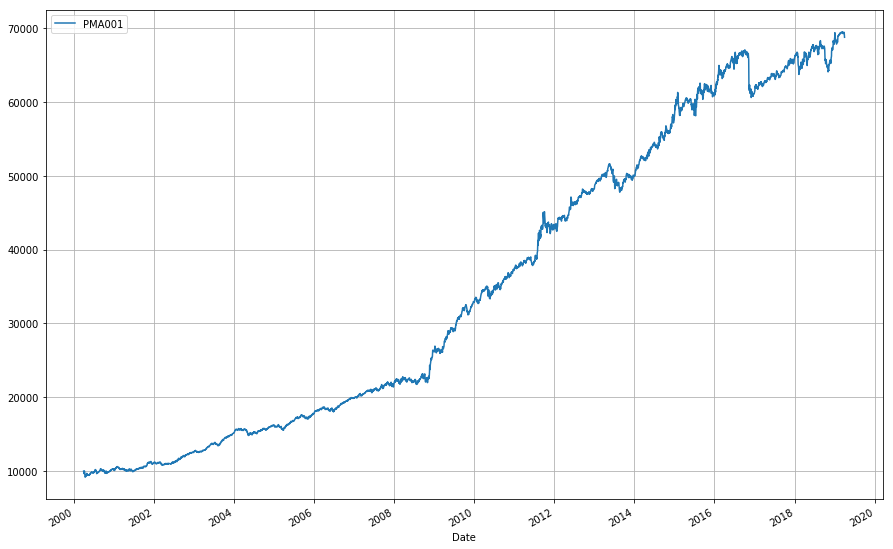

In [64]:
# elligibility rule
SMA = prices_m.rolling(p.risk_lookback).mean().dropna()
rebalance_dates = SMA.index
rule = prices_m.loc[rebalance_dates][p.assets] > SMA[p.assets]

# fixed weight allocation
weights = p.allocations * rule

# downside protection
weights[p.cash_proxy] = 1 - weights[p.assets].sum(axis=1)

# backtest
p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15, 10), grid=True, legend=True, label=name)

# SCRATCH